The primary goal of this project is to predict whether a customer will subscribe to a term deposit, achieving at least 81% accuracy through 5‑fold cross validation. Beyond prediction, we aim to identify customer segments most likely to invest, highlight the key features driving purchase decisions, and provide interpretable insights that empower clients to prioritize outreach strategies effectively

# libraries

In [28]:
# basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Handling imbalanced dataset 
from imblearn.over_sampling import SMOTE 
from collections import Counter
# Convert Categorical Variable to Numeric
from sklearn.preprocessing import LabelEncoder 

# Modeling

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import KFold, cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
Data=pd.read_csv("term-deposit-marketing-2020.csv")
Data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## Attributes:

- age : age of customer (numeric)

- job : type of job (categorical)

- marital : marital status (categorical)

- education (categorical)

- default: has credit in default? (binary)

- balance: average yearly balance, in euros (numeric)

- housing: has a housing loan? (binary)

- loan: has personal loan? (binary)

- contact: contact communication type (categorical)

- day: last contact day of the month (numeric)

- month: last contact month of year (categorical)

- duration: last contact duration, in seconds (numeric)

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

- Output (desired target): y - has the client subscribed to a term deposit? (binary)



# Getting the Data Info

In [3]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


- Rows and columns: 40000 Rows, 14 columns
- Types of variables: 5 Numeric variables, 9 Categorical  variables

# Checking Missing Values

In [4]:
Data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

- It appears that the dataframe does not contain missing values overall. However, certain features do include null entries—specifically, 3,209 in Balance and 3 in Duration. Let’s examine a sample of these subsets.


# Data Visualization for Categorical Variables

- Categorical Variables: job, marital,education, default,housing, loan, contact,month,deposit

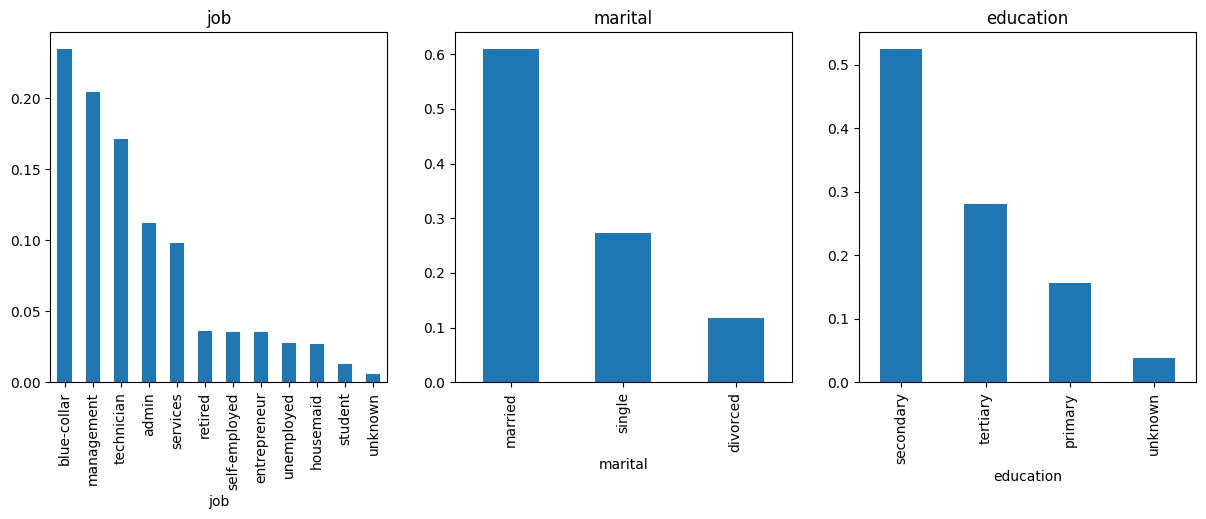

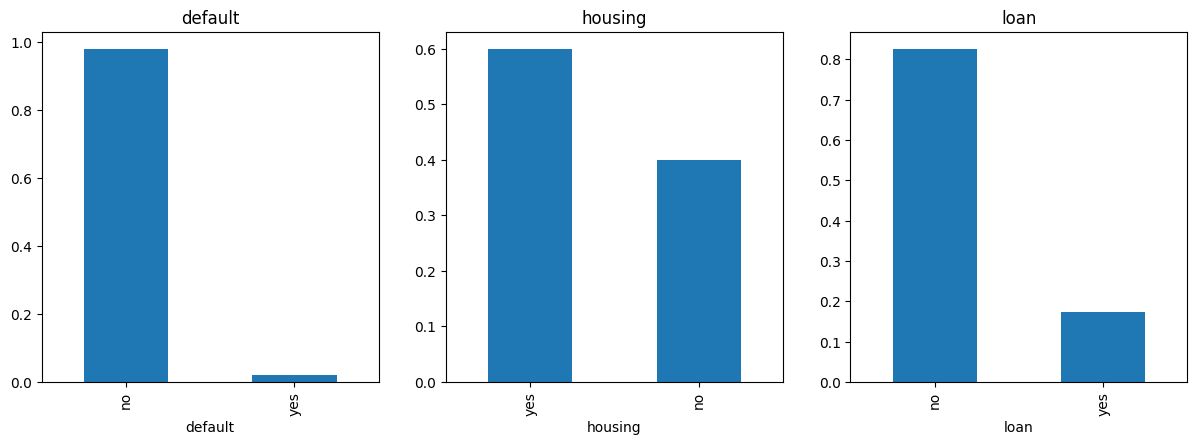

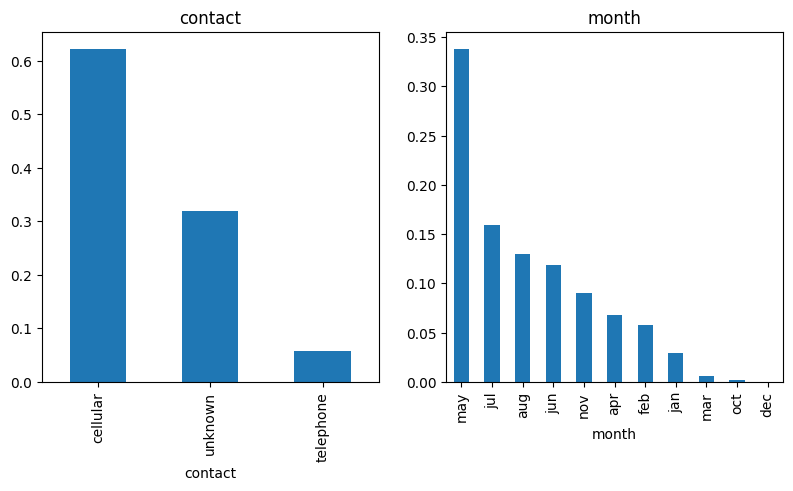

In [5]:
# 2.1.2. categorical variables

plt.figure(1)

plt.subplot(241)

Data['job'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='job')

plt.subplot(242)
Data['marital'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='marital')

plt.subplot(243)
Data['education'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='education')

plt.show()


plt.figure(2)

plt.subplot(241)
Data['default'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='default' )

plt.subplot(242)
Data['housing'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='housing')

plt.subplot(243)
Data['loan'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='loan')

plt.show()

plt.figure(1)

plt.subplot(241)
Data['contact'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='contact')

plt.subplot(242)
Data['month'].value_counts(normalize=True).plot.bar(figsize=(20,10),title='month')



plt.show()

- From the results above, we can see that qualitative variables are divided into 2 groups: 3 binary variables, and 5 multi categorical variables
- The features which are having unknown class is job, education, contact

# Replacing unknown class with mode of the particular feature

In [6]:
Data["job"].replace(["unknown"],Data["job"].mode(),inplace = True)
Data["education"].replace(["unknown"],Data["education"].mode(),inplace = True)
Data["contact"].replace(["unknown"],Data["contact"].mode(),inplace = True)

# Check for imbalance data

Text(0.5, 1.0, 'Distribution of client subscribed to a term deposit')

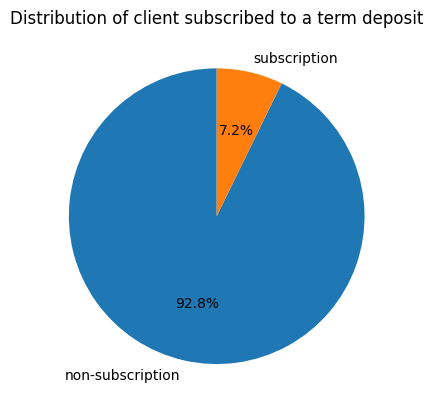

In [7]:
# y_count=Data["y"].value_counts(normalize=True)
labels = ['non-subscription', 'subscription']
Data["y"].value_counts(normalize=True)
plt.pie(Data['y'].value_counts(),labels=labels,autopct='%1.1f%%', startangle=90)
plt.title('Distribution of client subscribed to a term deposit')

- Since 92% of clients did not subscribe to a term deposit, the dataset is highly imbalanced. Therefore, relying solely on accuracy would be misleading. Instead, it is more appropriate to evaluate the model using alternative metrics such as recall, precision, or the F1 score.

 # Convert Categorical Variable to Numeric

- Transforming categorical data into numerical form is a crucial step in preprocessing for machine learning. Since most algorithms operate on numerical inputs, this conversion guarantees compatibility, enhances model accuracy, and enables more effective feature engineering.

In [8]:
from sklearn.preprocessing import LabelEncoder
lbe = LabelEncoder()
Data.job = lbe.fit_transform(Data.job)
Data.marital = lbe.fit_transform(Data.marital)
Data.education = lbe.fit_transform(Data.education)
Data.default = lbe.fit_transform(Data.default)
Data.housing = lbe.fit_transform(Data.housing)
Data.loan = lbe.fit_transform(Data.loan)
Data.contact = lbe.fit_transform(Data.contact)
Data.month = lbe.fit_transform(Data.month)
Data.y=lbe.fit_transform(Data.y)

# Checking for Correlation among the Predictors

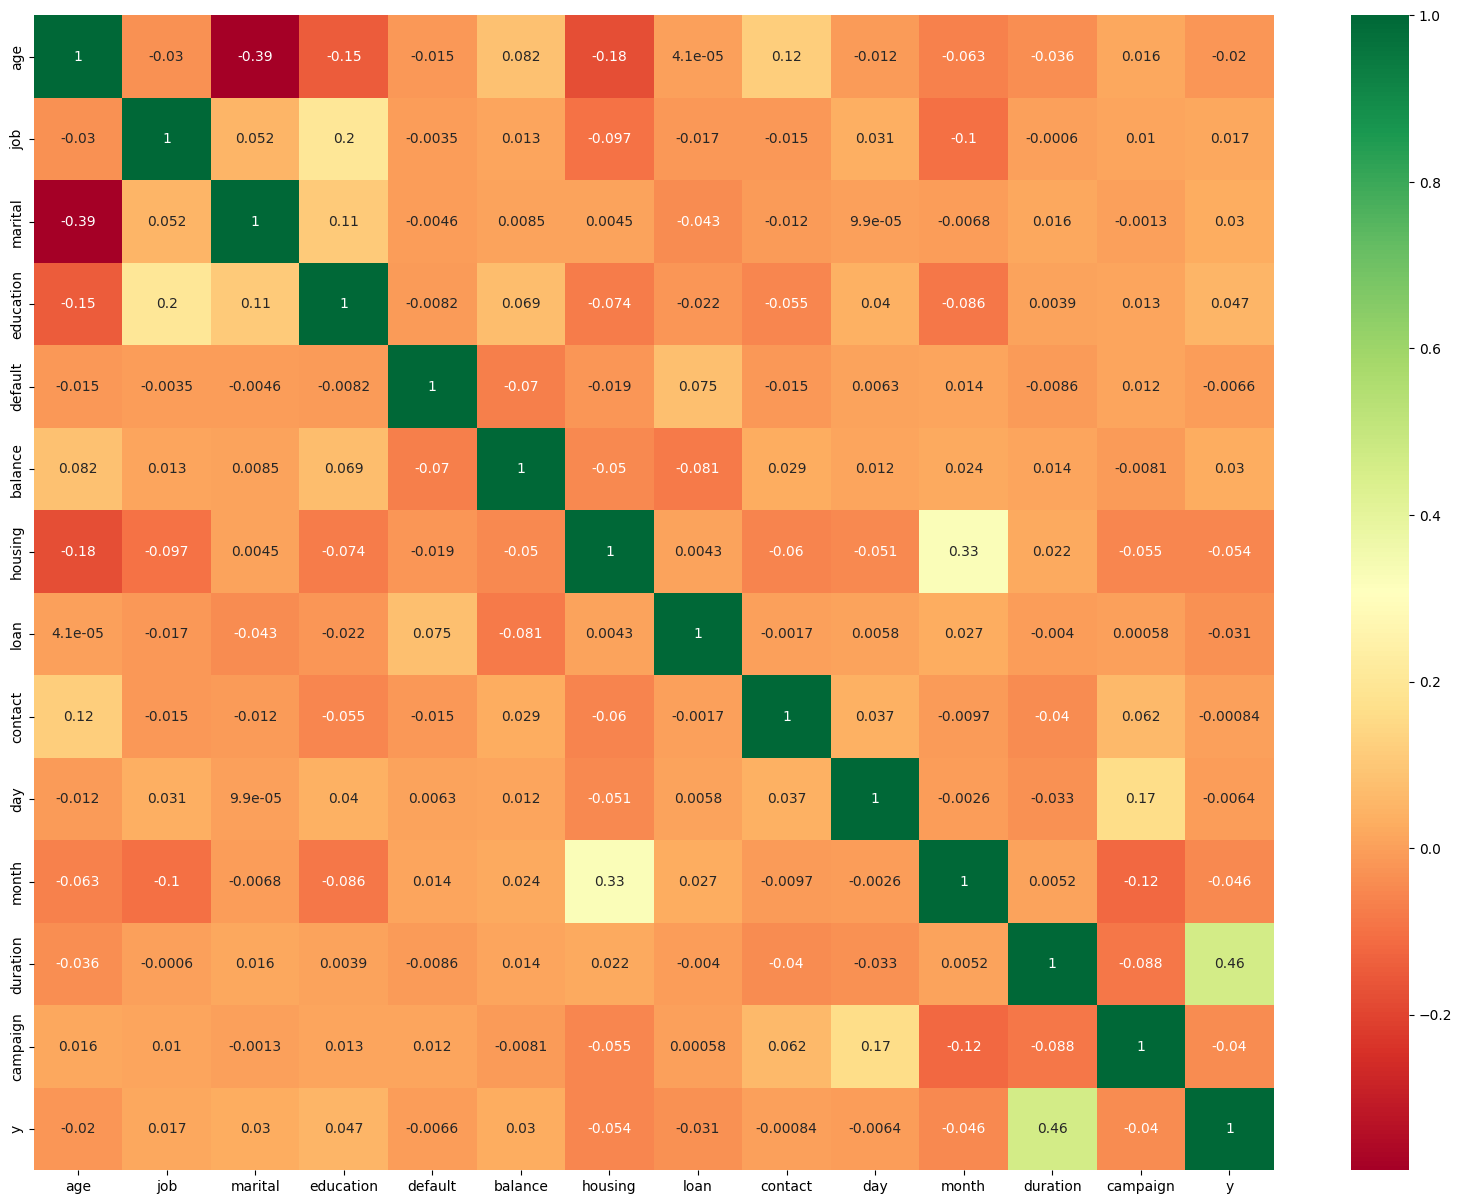

In [9]:
corr = Data.corr()

plt.figure(figsize=(20,15))
sns.heatmap(corr, annot=True, cmap='RdYlGn')
plt.show()

### We can see clearly that : 

- Most correlated with target feature is duration Variable
- we can infer that month and contact are more correlated, also month and housing.

# Handling Class Imbalance Using SMOTE

SMOTE helps balance datasets by creating new examples for the smaller class instead of just copying old ones. It works by picking a data point from the minority class, finding its closest neighbors, and then making a new point somewhere between the chosen one and one of those neighbors.

In [10]:
Y=Data['y']
X = Data.drop('y',axis = 1)
Y_train, Y_test, X_train, X_test = train_test_split(Y, X, test_size=0.2, random_state=42)

In [11]:
print("Class distribution before SMOTE:", Counter(Y_train))
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
print("Class distribution after SMOTE:", Counter(Y_train_resampled))

Class distribution before SMOTE: Counter({0: 29680, 1: 2320})
Class distribution after SMOTE: Counter({0: 29680, 1: 29680})


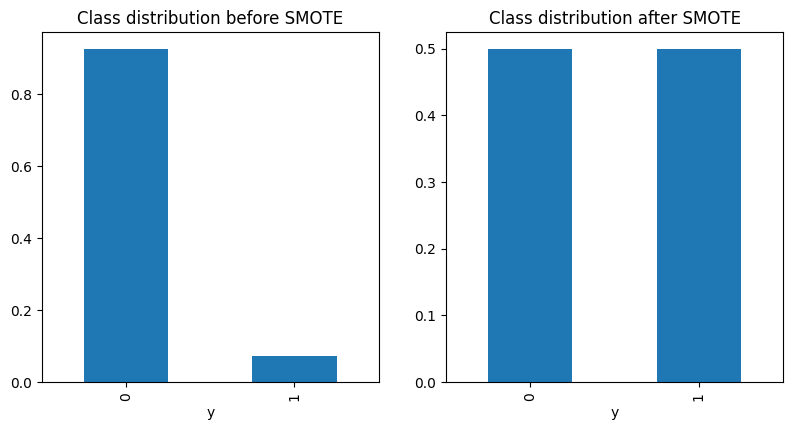

In [12]:
plt.figure(1)
plt.subplot(241)
Y_train.value_counts(normalize=True).plot.bar(figsize=(20,10),title='Class distribution before SMOTE')
plt.subplot(242)
Y_train_resampled.value_counts(normalize=True).plot.bar(figsize=(20,10),title='Class distribution after SMOTE')
plt.show()

In [13]:
X_train_resampled["Y"]=Y_train_resampled
train=X_train_resampled
train.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,Y
0,32,4,1,2,0,184,1,0,0,14,5,238,3,0
1,44,3,1,0,0,1109,1,1,0,29,5,176,4,0
2,37,4,2,2,1,-25,0,0,0,17,6,136,2,0
3,59,5,1,2,0,6108,1,0,0,17,5,796,2,0
4,49,4,1,2,0,0,1,0,0,18,9,102,1,0


In [14]:
X_test['Y']=Y_test
test=X_test
test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,Y
32823,48,4,0,2,0,266,1,0,0,17,0,198,2,0
16298,53,5,0,1,0,84,0,0,0,23,5,336,1,0
28505,43,4,0,2,0,3578,0,0,0,29,4,376,2,0
6689,38,9,1,1,0,133,1,0,0,28,8,156,1,0
26893,42,4,1,2,0,4014,1,0,0,21,9,149,4,0


In [15]:
print("new test shape:",test.shape)
print("new train shape:",train.shape)
#Data.shape
#test.shape

new test shape: (8000, 14)
new train shape: (59360, 14)


Text(0.5, 1.0, 'Distribution of client subscribed to a term deposit')

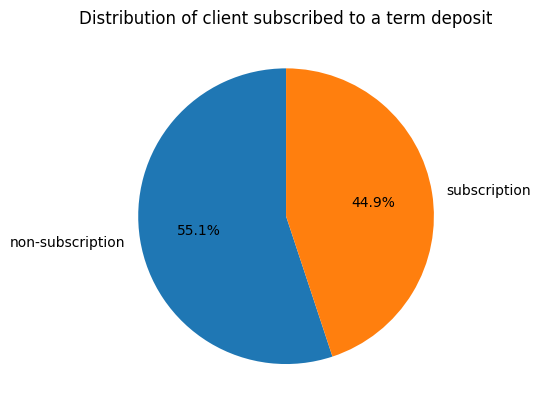

In [16]:
New_Data=pd.concat([train,test])
New_Data.shape


###############################3


labels = ['non-subscription', 'subscription']
New_Data["Y"].value_counts(normalize=True)
plt.pie(New_Data['Y'].value_counts(),labels=labels,autopct='%1.1f%%', startangle=90)
plt.title('Distribution of client subscribed to a term deposit')

In [20]:
Y=New_Data['Y']
X = New_Data.drop('Y',axis = 1)
Y_train, Y_test, X_train, X_test = train_test_split(Y, X, test_size=0.2, random_state=42)


# features Selection 

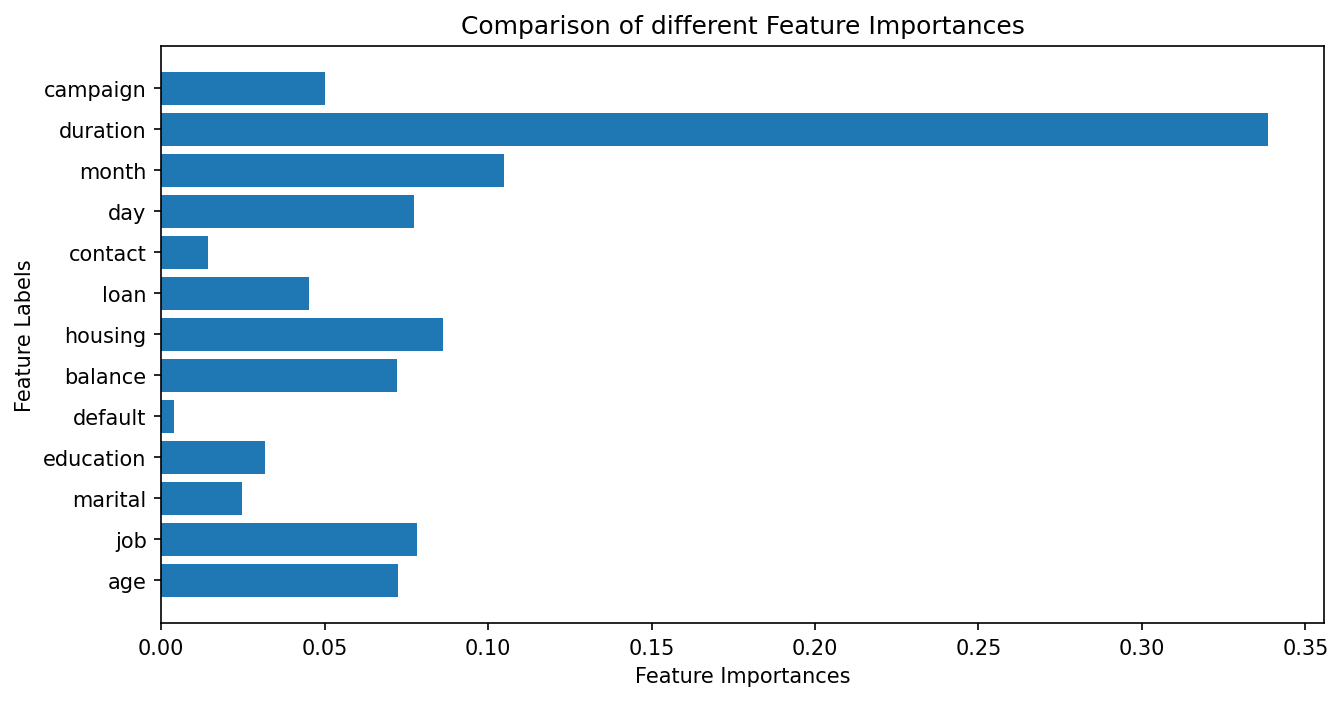

In [59]:
from sklearn.ensemble import ExtraTreesClassifier
plt.figure(figsize=(10, 5), dpi=150)
model_ET = ExtraTreesClassifier()
model_ET.fit(X_train,Y_train)

feat_importances =model_ET.feature_importances_
plt.barh(X.columns, feat_importances)
plt.xlabel('Feature Importances')
plt.ylabel('Feature Labels')
plt.title('Comparison of different Feature Importances')
plt.show()

- The plot indicates that call duration is the most influential feature in our dataset. This finding supports the earlier proposal highlighting its significance for prediction. Therefore, the company should prioritize the duration of calls as a key factor in its strategy.

# 5‑fold cross validation Model

In [72]:

k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize the RandomForestClassifier model
model_KF = RandomForestClassifier(random_state=42)

# Perform Cross Validation
scores = cross_val_score(model_KF, X, Y, cv=kf, scoring='accuracy')

print(f"Accuracy for each fold: {scores}")

average_accuracy = np.mean(scores) 
print(f"Average Accuracy: {average_accuracy:.2f}")

Accuracy for each fold: [0.94084026 0.94321556 0.94447743 0.94499703 0.94150831]
Average Accuracy: 0.94


From the results, it is evident that K‑Fold Averaging delivers significantly higher accuracy 

# Train multiple models for prediction using LazyPredict

In [23]:

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, Y_train, Y_test)
#print(models)
models



  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 24205, number of negative: 29683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 53888, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449172 -> initscore=-0.204015
[LightGBM] [Info] Start training from score -0.204015


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.94,0.94,0.94,0.94,5.91
ExtraTreesClassifier,0.94,0.94,0.94,0.94,3.91
XGBClassifier,0.94,0.94,0.94,0.94,0.76
BaggingClassifier,0.94,0.94,0.94,0.94,1.75
LGBMClassifier,0.92,0.92,0.92,0.92,3.89
LabelPropagation,0.91,0.92,0.92,0.92,2232.27
DecisionTreeClassifier,0.91,0.91,0.91,0.91,0.34
KNeighborsClassifier,0.90,0.90,0.90,0.90,6.55
SVC,0.89,0.89,0.89,0.89,68.04


The table generated by LazyPredict provides a quick comparison of multiple classification models based on key performance metrics such as Accuracy, Balanced Accuracy, ROC AUC, F1 Score, and computation time. These metrics help evaluate how well each model handles both balanced and imbalanced data, measures class‑separation ability, and balances precision with recall. Among all tested models, 

[Text(0, 0, 'RandomForestClassifier'),
 Text(1, 0, 'ExtraTreesClassifier'),
 Text(2, 0, 'XGBClassifier'),
 Text(3, 0, 'BaggingClassifier'),
 Text(4, 0, 'LGBMClassifier'),
 Text(5, 0, 'LabelPropagation'),
 Text(6, 0, 'DecisionTreeClassifier'),
 Text(7, 0, 'KNeighborsClassifier'),
 Text(8, 0, 'SVC'),
 Text(9, 0, 'ExtraTreeClassifier'),
 Text(10, 0, 'AdaBoostClassifier'),
 Text(11, 0, 'NuSVC'),
 Text(12, 0, 'LogisticRegression'),
 Text(13, 0, 'CalibratedClassifierCV'),
 Text(14, 0, 'LinearSVC'),
 Text(15, 0, 'SGDClassifier'),
 Text(16, 0, 'LinearDiscriminantAnalysis'),
 Text(17, 0, 'RidgeClassifierCV'),
 Text(18, 0, 'RidgeClassifier'),
 Text(19, 0, 'NearestCentroid'),
 Text(20, 0, 'BernoulliNB'),
 Text(21, 0, 'PassiveAggressiveClassifier'),
 Text(22, 0, 'Perceptron'),
 Text(23, 0, 'QuadraticDiscriminantAnalysis'),
 Text(24, 0, 'GaussianNB'),
 Text(25, 0, 'DummyClassifier')]

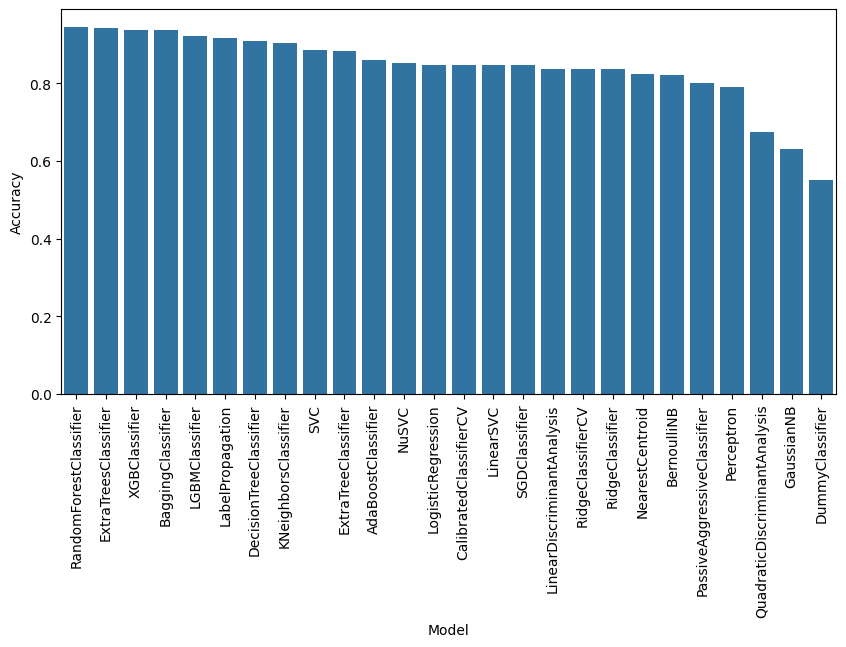

In [24]:
plt.figure(figsize=(10, 5))
# sns.set_theme(style="whitegrid")
order = models.sort_values("Accuracy", ascending=False).index
ax=sns.barplot(x=models.index, y="Accuracy", data=models, order=order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [25]:
print("Top Performing Model:\n")
display(models.Accuracy>0.93)

Top Performing Model:



Model
RandomForestClassifier            True
ExtraTreesClassifier              True
XGBClassifier                     True
BaggingClassifier                 True
LGBMClassifier                   False
LabelPropagation                 False
DecisionTreeClassifier           False
KNeighborsClassifier             False
SVC                              False
ExtraTreeClassifier              False
AdaBoostClassifier               False
NuSVC                            False
SGDClassifier                    False
LogisticRegression               False
CalibratedClassifierCV           False
LinearSVC                        False
LinearDiscriminantAnalysis       False
RidgeClassifierCV                False
RidgeClassifier                  False
NearestCentroid                  False
BernoulliNB                      False
PassiveAggressiveClassifier      False
Perceptron                       False
QuadraticDiscriminantAnalysis    False
GaussianNB                       False
DummyClassifier    

In [26]:
models[models['Accuracy']>0.93]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.94,0.94,0.94,0.94,5.91
ExtraTreesClassifier,0.94,0.94,0.94,0.94,3.91
XGBClassifier,0.94,0.94,0.94,0.94,0.76
BaggingClassifier,0.94,0.94,0.94,0.94,1.75


Based on the results of Lazy Predict, we choose the top 3 models, which are , RandomForestClassifier , Extra Tree Classifier, XGB Classifier 

In [61]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay

# Random Forest Classifier

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7421
           1       0.92      0.95      0.94      6051

    accuracy                           0.94     13472
   macro avg       0.94      0.94      0.94     13472
weighted avg       0.94      0.94      0.94     13472



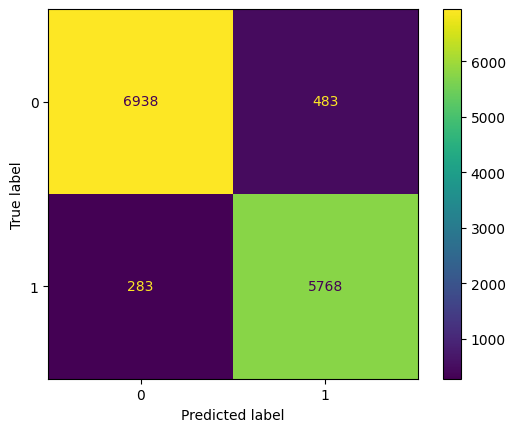

In [65]:
model_RF = RandomForestClassifier()
model_RF.fit(X_train, Y_train)
Y_pred_RF = model_RF.predict(X_test)
score_RF = accuracy_score(Y_test, Y_pred_RF)
print(classification_report(Y_test, Y_pred_RF))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_RF)
plt.show()

# Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7421
           1       0.93      0.95      0.94      6051

    accuracy                           0.94     13472
   macro avg       0.94      0.94      0.94     13472
weighted avg       0.94      0.94      0.94     13472



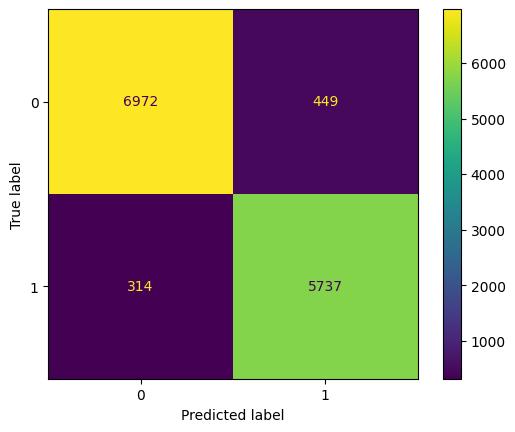

In [66]:
model_etc = ExtraTreesClassifier()
model_etc.fit(X_train, Y_train)
Y_pred_etc = model_etc.predict(X_test)
score_etc = accuracy_score(Y_test, Y_pred_etc)
print(classification_report(Y_test, Y_pred_etc))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_etc)
plt.show()

# XGB Classifier Model

Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7421
           1       0.92      0.94      0.93      6051

    accuracy                           0.94     13472
   macro avg       0.93      0.94      0.94     13472
weighted avg       0.94      0.94      0.94     13472



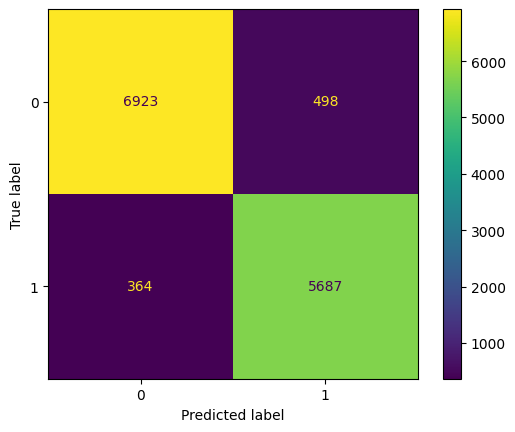

In [68]:
# XGB Classifier
import xgboost as xgb
model_xgb = xgb.XGBClassifier()                 # Maximum depth of the trees
model_xgb.fit(X_train, Y_train)
Y_pred_xgb = model_xgb.predict(X_test)
accuracy_xgb = accuracy_score(Y_test, Y_pred_xgb)
print(f"Accuracy: {accuracy_xgb:.2f}")
print(classification_report(Y_test, Y_pred_xgb))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_xgb)
plt.show()

# Conclusion

- Segment customer job roles into corporate tiers and prioritize outreach to tier‑1 professionals early in the campaign cycle.

- Based on the exploratory data analysis and model selection, it is evident that call duration plays a significant role in determining the outcome of the dataset. Leads who show greater interest in initiating a deposit tend to have more frequent interactions, with call lengths exceeding the average. Additionally, factors such as job role and educational background emerge as key influencers, strongly shaping the likelihood of a positive result.
- Reaching out to leads at the beginning of the new banking cycle (May–July) is advisable, as historical data indicates stronger positive outcomes during this period.
- Engage with leads more attentively to gather detailed insights, allowing the bank to tailor deposit plans effectively. This approach can extend call duration and significantly improve the chances of securing a deposit.